In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.io

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# definition of functions

In [24]:
def change_MAT_to_TXT(input_file, output_file):
    mat = scipy.io.loadmat(input_file)
    A = mat.__getitem__('A')
    file = open(output_file, 'w')
    for i in range(A.shape[0]):
        for j in A[i].nonzero()[1]:
            file.write(str(i) + ' ' + str(j) + ' ' + str(A[i, j]) + '\n')
    file.close()

In [25]:
def build_matrix(dataset, size_matrix):
    result = np.zeros([size_matrix, size_matrix])
    A = open(dataset, encoding='utf-8')
    for line in A:
        text = line.split()
        result[int(text[0]), int(text[1])] = 1 #abs(float(text[2]))
    return result

In [10]:
# this function build n realization of probabilistic graph
def build_probable_matrices(adjacency_matrix, num_realization, p):
    list_m = []
    for x in range(num_realization):
        temp = np.array(adjacency_matrix)
        for i in range(num_node):
            indexes = np.nonzero(temp[i])
            for j in indexes[0]:
                if j>= i :
                    temp[i, j] = np.random.uniform(0, 1, 1)[0] < p
                    temp[j,i] = temp[i,j]
        list_m.append(temp)
    return list_m

In [5]:
def get_neighbor(g, node):
    return np.nonzero(g[node])[0]


def IC1(list_g, S):
    score = 0
    for g in list_g:
        neighbor = []
        for s in S:
            neighbor.extend(np.nonzero(g[s])[0])
        score += len(list(set(neighbor)))
    score /= len(list_g)
    return score


def IC(list_g, S):
    spread = []
    for i in range(len(list_g)):
        g = list_g[i]
        new_active, A = S[:], S[:]
        while new_active:
            new_ones = []
            for node in new_active:
                new_ones += list(set(get_neighbor(g, node)))
            new_active = list(set(new_ones) - set(A))
            A += new_active
        spread.append(len(A))
    return np.mean(spread)

## **greedy hill climbing algorithm**

In [19]:
def greedy_hill_climbing(g, k):
    S, spread, timelapse, start_time = [], [], [], time.time()
    # Find k nodes with largest marginal gain
    kprime = min(k, num_node)
    for o in range(kprime):
        best_spread = 0
        for j in set(range(num_node)) - set(S):
            s = IC1(g, S + [j])
            if s >= best_spread:
                best_spread, node = s, j
        S.append(node)
        print("number " + str(o + 1) +" : " +str(node)+"   spread = "+str(best_spread))
        spread.append(best_spread)
        timelapse.append(time.time() - start_time)
    return S, spread, timelapse

## **Lazy hill climbing algorithm**

In [20]:
def lazy_hill_climbing(g, k):
    start_time = time.time()
    marg_gain = [IC1(g, [node]) for node in range(num_node)]
    Q = sorted(zip(range(num_node), marg_gain), key=lambda x: x[1], reverse=True)
    S,s, SPREAD = [Q[0][0]],Q[0][1], [Q[0][1]]
    Q, timelapse = Q[1:], [time.time() - start_time]
    print("number 1: "+str(S[0]))
    kprime = min(k, num_node)
    for o in range(1, kprime):
        check = False
        while not check:
            current = Q[0][0]
            Q[0] = (current, IC1(g, S + [current])-s)
            Q = sorted(Q, key=lambda x: x[1], reverse=True)
            check = (Q[0][0] == current)
        S.append(Q[0][0])
        s += Q[0][1]
        SPREAD.append(s)
        timelapse.append(time.time() - start_time)
        print("number "+str(o + 1) + " : "+ str(Q[0][0])+ "   spread = "+str(s))
        Q = Q[1:]
    return S, SPREAD, timelapse

# load data

In [8]:
# load file
input_file = '/content/drive/MyDrive/CN/facebook101_princton_weighted.mat'
txt_input_file = '/content/drive/MyDrive/CN/dataset.txt'
# change_MAT_to_TXT(input_file, txt_input_file)
num_node = 6596
adjacency_matrix = build_matrix(txt_input_file, num_node)
print("read input file and convert to matrix")

read input file and convert to matrix


In [17]:
import scipy
import networkx as nx
path = '/content/drive/MyDrive/CN/facebook101_princton_weighted.mat'
mat = scipy.io.loadmat(path)
A = mat['A']
G = nx.from_scipy_sparse_matrix(A)
print(nx.info(G))

Graph with 6596 nodes and 293320 edges


In [29]:
print(adjacency_matrix)
np.sum(adjacency_matrix)/2

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


293320.0

# make realization and run algorithms

In [16]:
# genetate realization
num_realization = 10
list_realization = build_probable_matrices(adjacency_matrix, num_realization, p=0.2)
print("generate " + str(num_realization) + " realization successfully")

generate 10 realization successfully


start running lazy_hill_climbing
number 1: 412
number 2 : 41   spread = 246.7
number 3 : 4894   spread = 355.2
number 4 : 6068   spread = 459.1
number 5 : 2259   spread = 550.7
number 6 : 1195   spread = 636.5
number 7 : 1232   spread = 717.0
number 8 : 5107   spread = 793.7
number 9 : 957   spread = 868.1
number 10 : 1286   spread = 939.0
lazy_hill_climbing output:   [412, 41, 4894, 6068, 2259, 1195, 1232, 5107, 957, 1286]
start running greedy_hill_climbing
number 1 : 412   spread = 126.6
number 2 : 41   spread = 246.7
number 3 : 4894   spread = 355.2
number 4 : 6068   spread = 459.1
number 5 : 2259   spread = 550.7
number 6 : 1195   spread = 636.5
number 7 : 1232   spread = 717.0
number 8 : 5107   spread = 793.7
number 9 : 957   spread = 868.1
number 10 : 1286   spread = 939.0
greedy_hill_climbing output: [412, 41, 4894, 6068, 2259, 1195, 1232, 5107, 957, 1286]


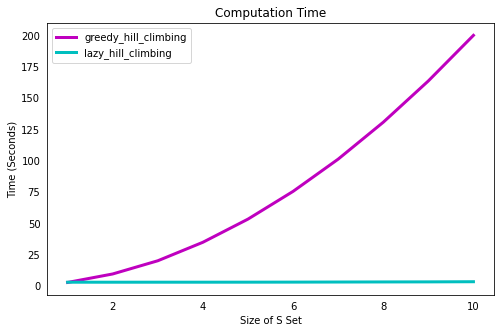

In [26]:
# Run algorithms
size_S = 10
print("start running lazy_hill_climbing")
lazy_hill_climbing_output = lazy_hill_climbing(list_realization, size_S)
print("lazy_hill_climbing output:   " + str(lazy_hill_climbing_output[0]))

print("start running greedy_hill_climbing")
greedy_hill_climbing_output = greedy_hill_climbing(list_realization, size_S)
print("greedy_hill_climbing output: " + str(greedy_hill_climbing_output[0]))

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False


plt.subplots()
plt.plot(range(1, len(greedy_hill_climbing_output[2]) + 1), greedy_hill_climbing_output[2], label="greedy_hill_climbing", color="m")
plt.plot(range(1, len(lazy_hill_climbing_output[2]) + 1), lazy_hill_climbing_output[2], label="lazy_hill_climbing", color="c")
plt.ylabel('Time (Seconds)')
plt.xlabel('Size of S Set')
plt.title('Computation Time')
plt.legend(loc=2)